Configure notebook...

In [1]:
%load_ext autoreload
%autoreload 2
%pwd

'/work/git/isaac-demo/ipynb'

Imports

In [3]:
from pathlib import Path
import datetime
import pandas as pd
from IPython.display import IFrame, HTML, Markdown, Image, display

Define benchmark

In [4]:
OUT_DIR_BASE = "../out"
BENCH = "cmsis_dsp/arm_abs_q31"
DATE = "latest"

Lookup directories

In [5]:
BENCH_DIR = Path(OUT_DIR_BASE) / BENCH
print("BENCH_DIR", BENCH_DIR)
assert BENCH_DIR.is_dir()
if DATE == "latest":
    dates = [f for f in BENCH_DIR.iterdir() if f.is_dir()]
    assert len(dates) > 0
    if len(dates) == 1:
        DATE = dates[0].name
    else:
        sorted_dates = sorted(dates, key=lambda x: datetime.datetime.strptime(x.name, "%Y%m%dT%H%M%S"))
        DATE = sorted_dates[-1].name
DATE_DIR = BENCH_DIR / DATE
assert DATE_DIR.is_dir()

print(f"Picked date: {DATE}")
print(f"Directory: {DATE_DIR}")

RUN = DATE_DIR / "run"
SESS = DATE_DIR / "sess"
WORK = DATE_DIR / "work"

PLOTS_DIR = SESS / "plots"

BENCH_DIR ../out/cmsis_dsp/arm_abs_q31
Picked date: 20250129T163749
Directory: ../out/cmsis_dsp/arm_abs_q31/20250129T163749


Check baseline benchmark (ISS)

In [6]:
REPORT = RUN / "report.csv"

COLS = ["Model", "Run Instructions", "Total ROM", "Total RAM"]
pd.read_csv(REPORT)[COLS]

,Model,Run Instructions,Total ROM,Total RAM
0,arm_abs_q31,1335,43608,3304


## Trace Analysis

### Identification of Bottlenecks

Per basic-block

In [10]:
IFrame(PLOTS_DIR / "runtime_per_llvm_bb.jpg", 700, 350)

Per function

In [18]:
IFrame(PLOTS_DIR / "runtime_per_func.jpg", 700, 350)

Per library

In [19]:
IFrame(PLOTS_DIR / "runtime_per_library.jpg", 700, 350)

Per object

In [20]:
IFrame(PLOTS_DIR / "runtime_per_object.jpg", 700, 350)

### Analyze instruction types

Per major opcode

In [21]:
IFrame(PLOTS_DIR / "runtime_per_opcode.jpg", 700, 350)

Per instruction name

In [22]:
IFrame(PLOTS_DIR / "runtime_per_instr.jpg", 700, 350)

### Choose BBs for ISE identification

In [31]:
CHOICES = SESS / "table" / "choices.pkl"

choices_df = pd.read_pickle(CHOICES)
choices_df

,func_name,file,bb_name,rel_weight,num_instrs,freq
0,arm_abs_q31,/nas/ei/home/ga87puy/src/CMSIS-DSP/Source/Basi...,%bb.21,0.154083,5,40.0
1,arm_abs_q31,/nas/ei/home/ga87puy/src/CMSIS-DSP/Source/Basi...,%bb.13,0.092450,3,40.0
2,arm_abs_q31,/nas/ei/home/ga87puy/src/CMSIS-DSP/Source/Basi...,%bb.9,0.092450,3,40.0
3,arm_abs_q31,/nas/ei/home/ga87puy/src/CMSIS-DSP/Source/Basi...,%bb.17,0.092450,3,40.0
4,arm_abs_q31,/nas/ei/home/ga87puy/src/CMSIS-DSP/Source/Basi...,%bb.29,0.076271,3,33.0
5,arm_abs_q31,/nas/ei/home/ga87puy/src/CMSIS-DSP/Source/Basi...,%bb.28,0.076271,3,33.0
6,arm_abs_q31,/nas/ei/home/ga87puy/src/CMSIS-DSP/Source/Basi...,%bb.27,0.076271,3,33.0
7,arm_abs_q31,/nas/ei/home/ga87puy/src/CMSIS-DSP/Source/Basi...,%bb.30,0.061633,2,40.0
8,arm_abs_q31,/nas/ei/home/ga87puy/src/CMSIS-DSP/Source/Basi...,%bb.2,0.061633,2,40.0


In [41]:
num_choices = len(choices_df)
choices_sum_weights = choices_df["rel_weight"].sum()
max_num_instrs = choices_df["num_instrs"].max()
num_choices, choices_sum_weights, max_num_instrs

(9, 0.783513097072419, 5)

## Identification of ISE candidates

### Per Func+BB

Filtered candidates

,Label,Count
0,Filtered (Operands),1


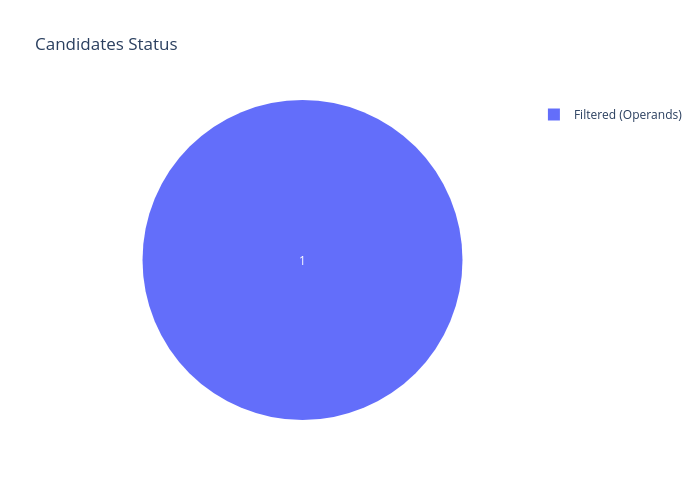

,Label,Count
0,Filtered (Mem),2


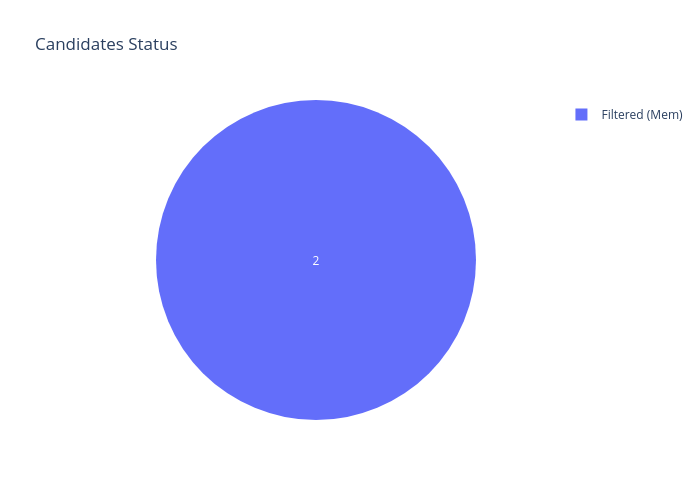

,Label,Count
0,Filtered (Mem),2


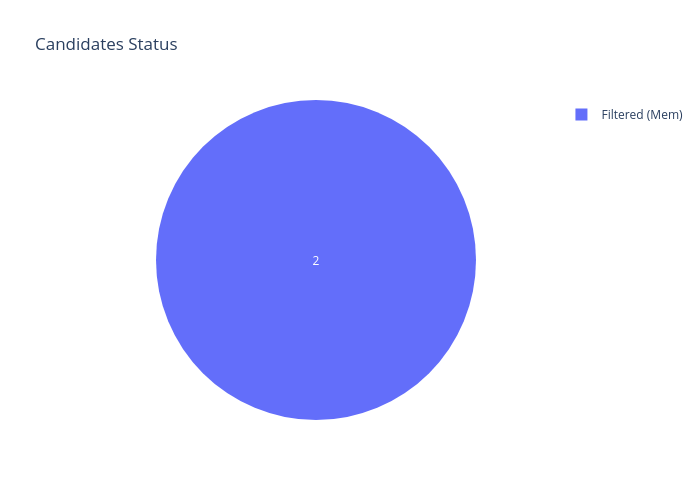

,Label,Count
0,Filtered (Mem),2


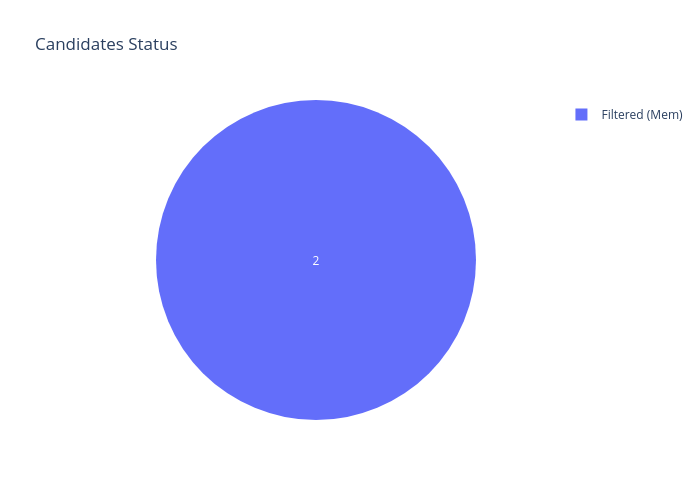

,Label,Count


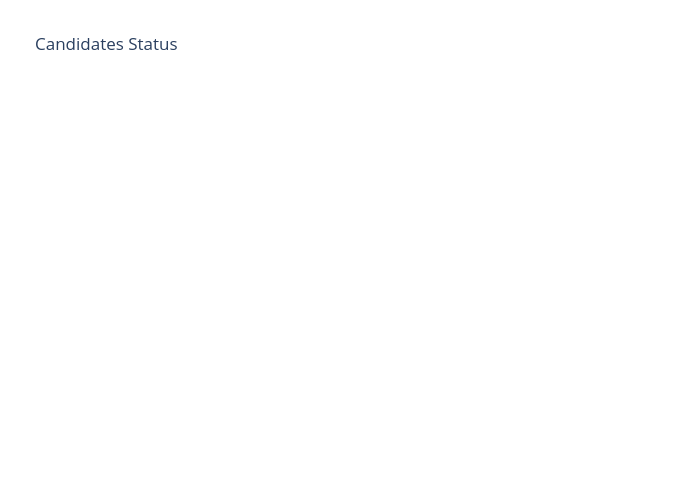

,Label,Count


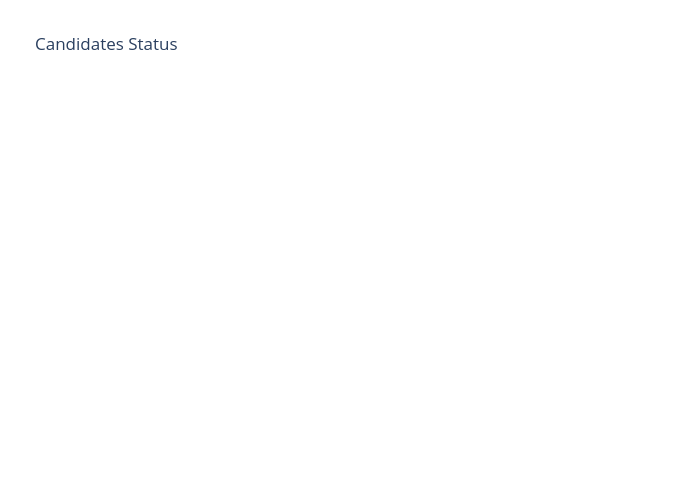

,Label,Count


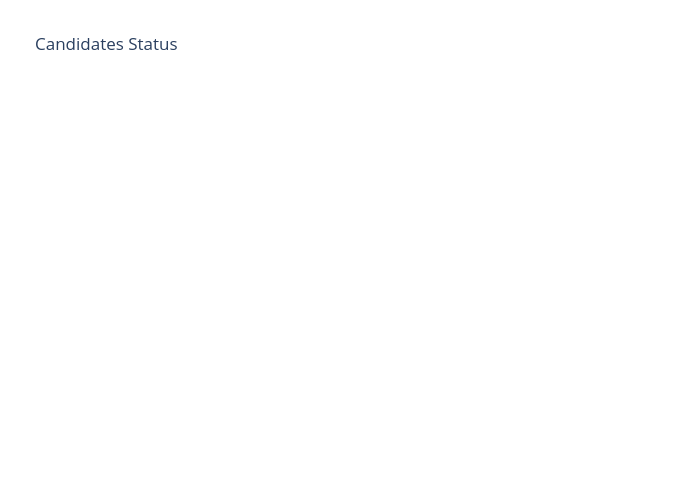

,Label,Count


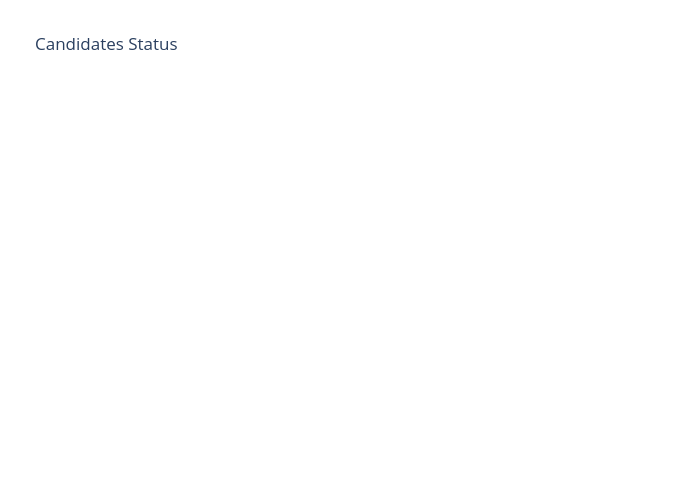

,Label,Count
0,Filtered (Mem),2


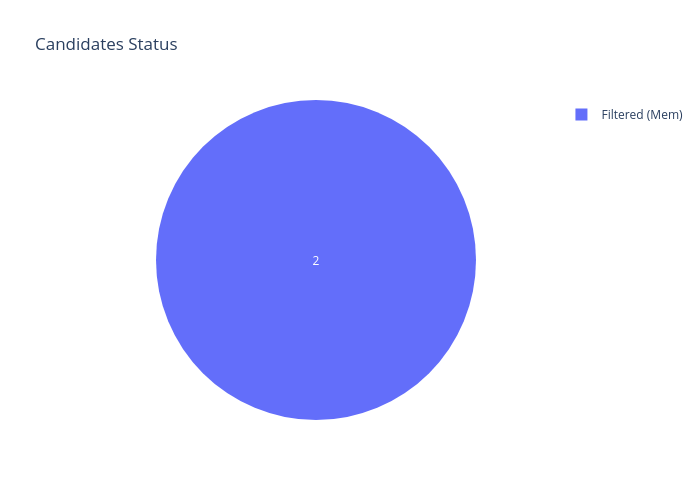

In [42]:
for _, row_data in choices_df.iterrows():
    func_name = row_data["func_name"]
    bb_name = row_data["bb_name"]
    func_bb_dir = WORK / f"{func_name}_{bb_name}_0"  # TODO: chekc suffix?
    pie_csv = func_bb_dir / "pie.csv"
    pie_img = func_bb_dir / "pie.png"
    display(HTML(f"<h2>Func: {func_name}, BB: {bb_name}</h2>"))
    display(pd.read_csv(pie_csv))
    display(Image(pie_img))

Generated variations 

,Label,Count
0,Unknown,1


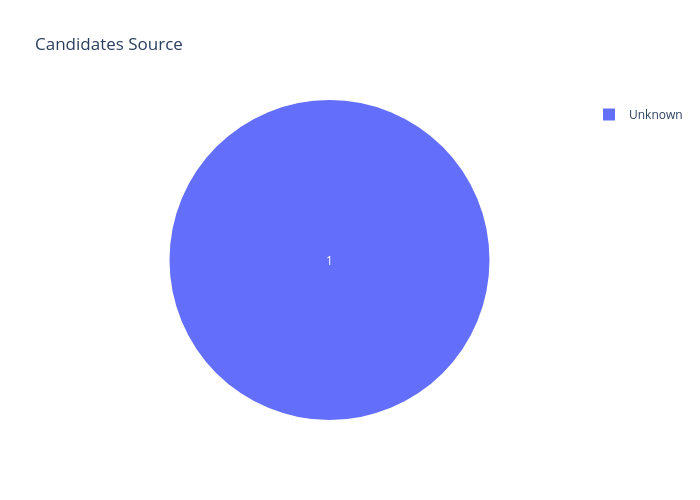

,Label,Count
0,Unknown,2


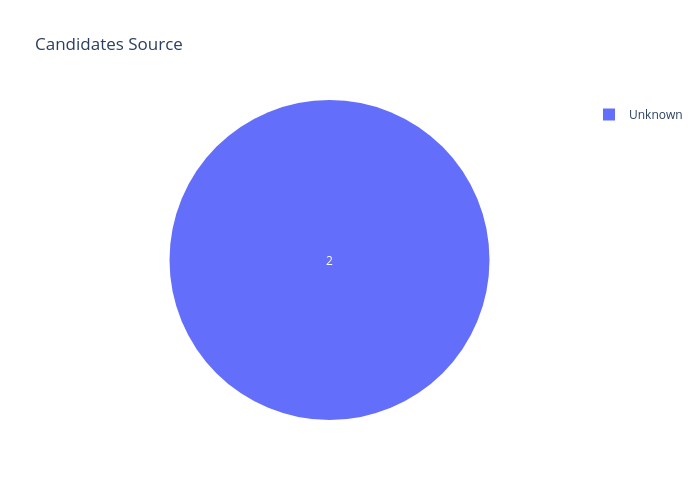

,Label,Count
0,Unknown,2


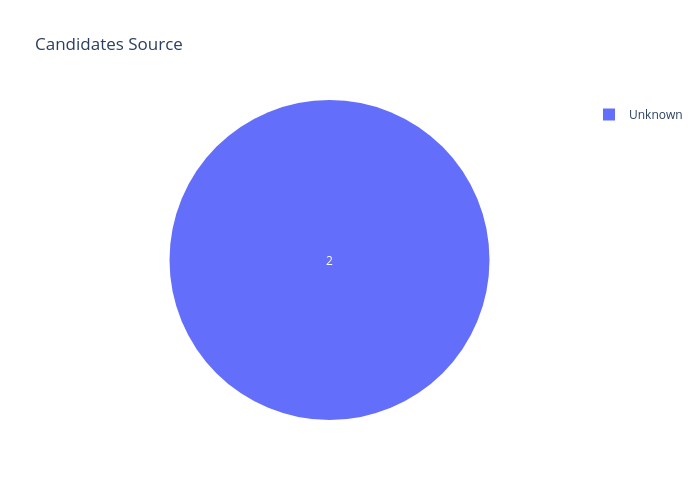

,Label,Count
0,Unknown,2


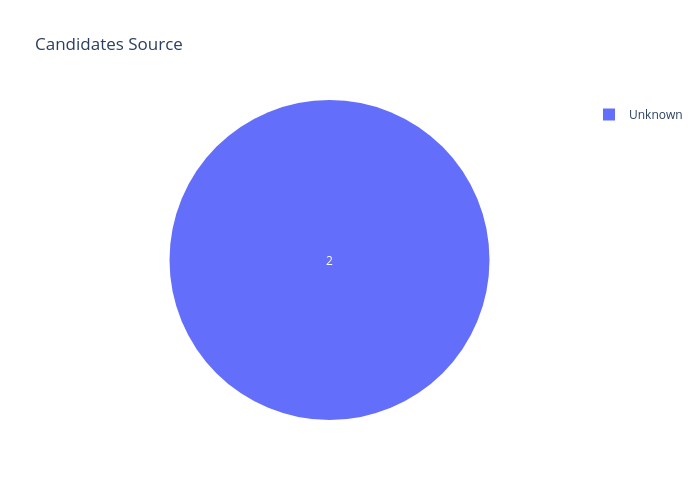

,Label,Count


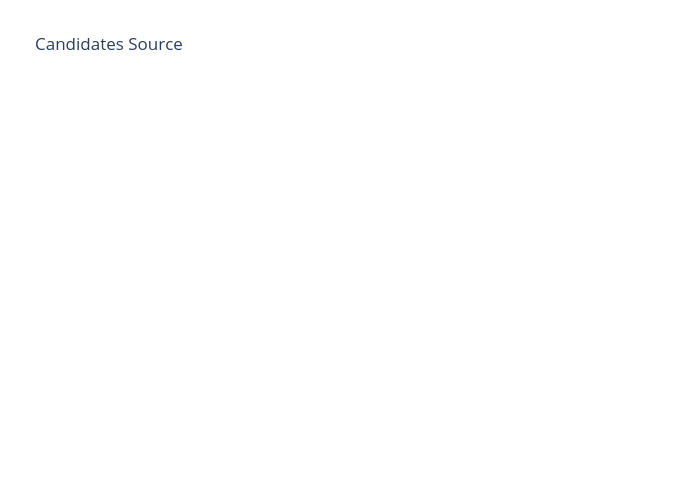

,Label,Count


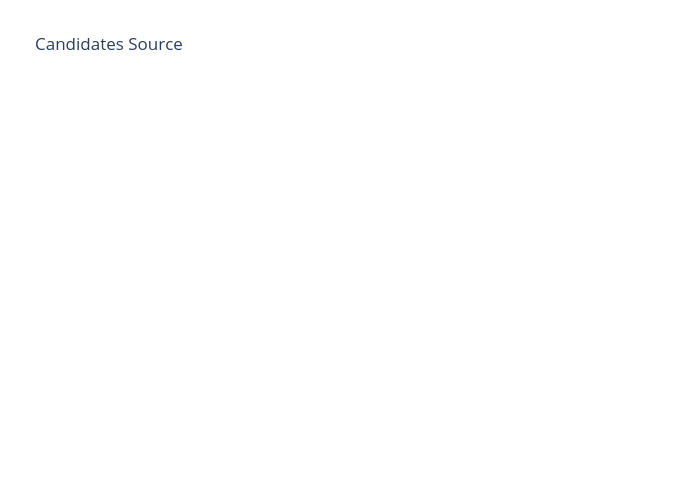

,Label,Count


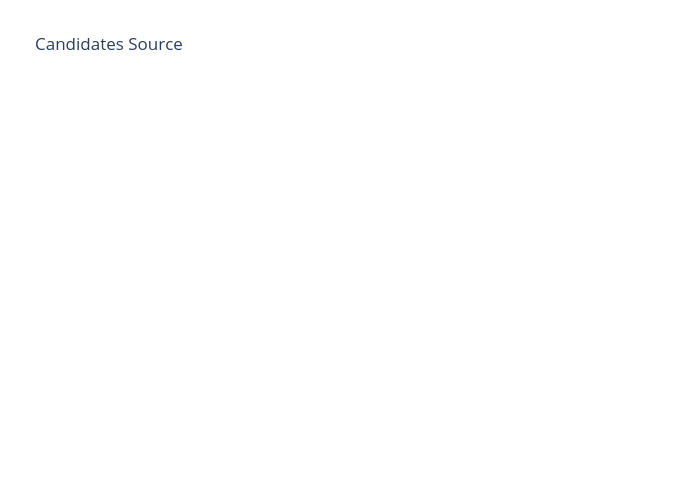

,Label,Count


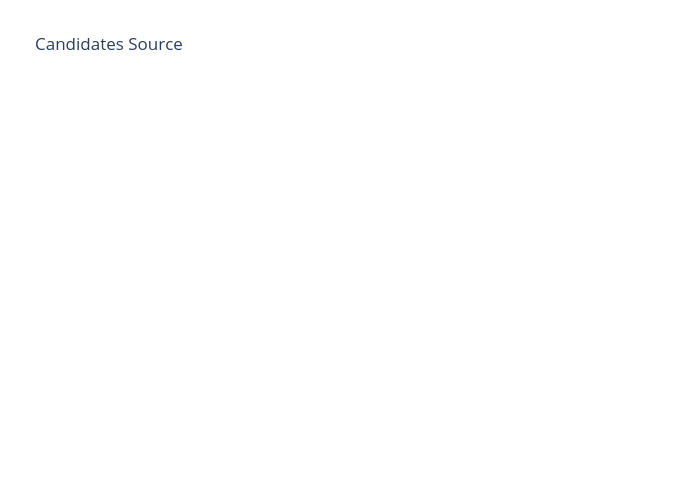

,Label,Count
0,Unknown,2


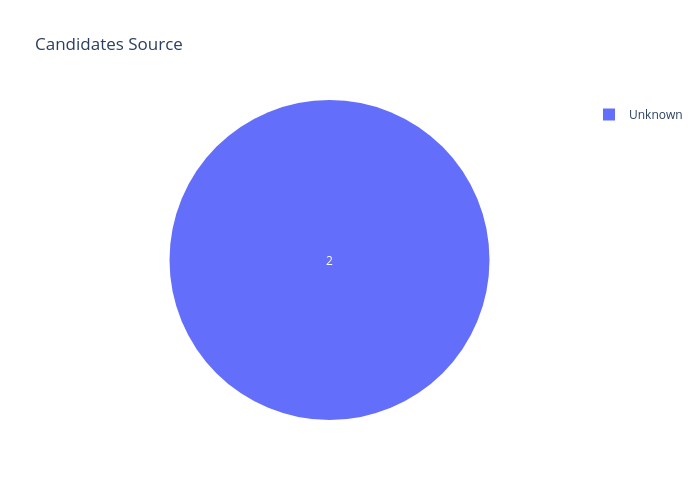

In [43]:
for _, row_data in choices_df.iterrows():
    func_name = row_data["func_name"]
    bb_name = row_data["bb_name"]
    func_bb_dir = WORK / f"{func_name}_{bb_name}_0"  # TODO: check suffix?
    pie2_csv = func_bb_dir / "pie2.csv"
    pie2_img = func_bb_dir / "pie2.png"
    display(HTML(f"<h2>Func: {func_name}, BB: {bb_name}</h2>"))
    display(pd.read_csv(pie2_csv))
    display(Image(pie2_img))

Profile

In [44]:
for _, row_data in choices_df.iterrows():
    func_name = row_data["func_name"]
    bb_name = row_data["bb_name"]
    func_bb_dir = WORK / f"{func_name}_{bb_name}_0"  # TODO: chekc suffix?
    times_csv = func_bb_dir / "times.csv"
    display(HTML(f"<h2>Func: {func_name}, BB: {bb_name}</h2>"))
    display(pd.read_csv(times_csv))

,Name,Secs,Secs (rel.)
0,Settings Validation,0.000089,0.000069
1,Connect to DB,0.000162,0.000125
2,Query func from DB,0.004749,0.003643
3,Query candidates from DB,0.006981,0.005355
4,Conversion to NX (func),0.028177,0.021614
5,Conversion to NX (candidates),0.000676,0.000518
6,Subgraph Generation,0.003776,0.002896
7,Relabeling,0.001792,0.001374
8,Dumping GF graph,0.012720,0.009757
9,I/O Analysis,0.001439,0.001104


,Name,Secs,Secs (rel.)
0,Settings Validation,0.000090,0.000071
1,Connect to DB,0.000142,0.000112
2,Query func from DB,0.004738,0.003717
3,Query candidates from DB,0.003741,0.002935
4,Conversion to NX (func),0.025772,0.020216
5,Conversion to NX (candidates),0.001150,0.000902
6,Subgraph Generation,0.003703,0.002905
7,Relabeling,0.001823,0.001430
8,Dumping GF graph,0.012436,0.009755
9,I/O Analysis,0.002065,0.001620


,Name,Secs,Secs (rel.)
0,Settings Validation,0.000093,0.000069
1,Connect to DB,0.000158,0.000116
2,Query func from DB,0.009252,0.006808
3,Query candidates from DB,0.008267,0.006083
4,Conversion to NX (func),0.061034,0.044910
5,Conversion to NX (candidates),0.001658,0.001220
6,Subgraph Generation,0.003986,0.002933
7,Relabeling,0.001858,0.001367
8,Dumping GF graph,0.012798,0.009417
9,I/O Analysis,0.002054,0.001511


,Name,Secs,Secs (rel.)
0,Settings Validation,0.000086,0.000067
1,Connect to DB,0.000163,0.000127
2,Query func from DB,0.005907,0.004594
3,Query candidates from DB,0.008239,0.006408
4,Conversion to NX (func),0.064210,0.049937
5,Conversion to NX (candidates),0.001658,0.001290
6,Subgraph Generation,0.004103,0.003191
7,Relabeling,0.001858,0.001445
8,Dumping GF graph,0.012728,0.009898
9,I/O Analysis,0.002031,0.001580


,Name,Secs,Secs (rel.)
0,Settings Validation,0.000089,0.000068
1,Connect to DB,0.000171,0.000130
2,Query func from DB,0.005249,0.004016
3,Query candidates from DB,0.008797,0.006731
4,Conversion to NX (func),0.066205,0.050656
5,Conversion to NX (candidates),0.000127,0.000097
6,Subgraph Generation,0.003837,0.002936
7,Relabeling,0.001695,0.001297
8,Dumping GF graph,0.012765,0.009767
9,I/O Analysis,0.000202,0.000154


,Name,Secs,Secs (rel.)
0,Settings Validation,0.000085,0.000068
1,Connect to DB,0.000163,0.000129
2,Query func from DB,0.005378,0.004264
3,Query candidates from DB,0.008100,0.006423
4,Conversion to NX (func),0.053362,0.042314
5,Conversion to NX (candidates),0.000142,0.000113
6,Subgraph Generation,0.004166,0.003303
7,Relabeling,0.001697,0.001346
8,Dumping GF graph,0.012785,0.010138
9,I/O Analysis,0.000195,0.000155


,Name,Secs,Secs (rel.)
0,Settings Validation,0.000090,0.000076
1,Connect to DB,0.000188,0.000157
2,Query func from DB,0.004699,0.003938
3,Query candidates from DB,0.007189,0.006025
4,Conversion to NX (func),0.026763,0.022429
5,Conversion to NX (candidates),0.000124,0.000104
6,Subgraph Generation,0.003687,0.003090
7,Relabeling,0.001663,0.001393
8,Dumping GF graph,0.012660,0.010610
9,I/O Analysis,0.000225,0.000189


,Name,Secs,Secs (rel.)
0,Settings Validation,0.000096,0.000074
1,Connect to DB,0.000171,0.000132
2,Query func from DB,0.009263,0.007148
3,Query candidates from DB,0.008041,0.006204
4,Conversion to NX (func),0.058625,0.045237
5,Conversion to NX (candidates),0.000159,0.000122
6,Subgraph Generation,0.003787,0.002922
7,Relabeling,0.001750,0.001350
8,Dumping GF graph,0.012762,0.009848
9,I/O Analysis,0.000209,0.000162


,Name,Secs,Secs (rel.)
0,Settings Validation,0.000096,0.000074
1,Connect to DB,0.000166,0.000127
2,Query func from DB,0.004978,0.003817
3,Query candidates from DB,0.008222,0.006304
4,Conversion to NX (func),0.027233,0.020879
5,Conversion to NX (candidates),0.001149,0.000881
6,Subgraph Generation,0.003806,0.002918
7,Relabeling,0.001855,0.001422
8,Dumping GF graph,0.012821,0.009829
9,I/O Analysis,0.002089,0.001602


### Combined results

Pairwise overlaps

In [45]:
overlaps_file = WORK / "overlaps.csv"
pd.read_csv(overlaps_file)

,x,y,nodes,size
0,0,1,set(),0
1,0,2,set(),0
2,0,3,set(),0
3,0,4,set(),0
4,0,5,set(),0
5,0,6,set(),0
6,0,7,set(),0
7,0,8,set(),0
8,1,2,set(),0
9,1,3,set(),0


Venn diagram

In [46]:
venn_file = WORK / "venn.jpg"
if len(choices_df) in [2, 3]:
    if venn_file.is_file():
        display(IFrame(venn_file, 700, 350))

Sankey diagram (duplicates vs. unqiue instructions)

In [47]:
sankey_file =  WORK / "sankey.md"
with open(sankey_file, "r") as f:
    content = f.read()
display(Markdown(content))


```mermaid
---
config:
  sankey:
    showValues: true
---
sankey-beta

%% source,target,value
Set0,Merged,0
Set1,Merged,0
Set2,Merged,0
Set3,Merged,0
Set4,Merged,0
Set5,Merged,0
Set6,Merged,0
Set7,Merged,0
Set8,Merged,0
Merged,Duplicates,0
Merged,Unique,0
Unique,Topk,0

```


### Analyse combined index

In [48]:
combined_index_yaml = WORK / "combined_index.yml"
names_csv = WORK / "names.csv"
names_df = pd.read_csv(names_csv)
num_candidates = len(names_df)
names_df

,instr,instr_lower


In [49]:
import yaml
with open(combined_index_yaml, "r") as f:
    combined_index_data = yaml.safe_load(f)

Analyze Encoding Footprint

In [50]:
import sys
sys.path.append("../scripts/")
from analyze_encoding import collect_weights, get_enc_weights_df, plot_enc_pie_multi, get_enc_score_df

In [51]:
enc_size = 32

total_weight, weight_per_instr, footprint_per_instr, rest_weight, bits_per_instr = collect_weights(combined_index_data, enc_size=enc_size)
enc_weights_df = get_enc_weights_df(total_weight, weight_per_instr, bits_per_instr, footprint_per_instr)
# enc_weights_df
enc_score_df = get_enc_score_df(enc_weights_df)
enc_score_df

KeyError: "['footprint'] not in index"

In [ ]:
total_weight

Pie chart for enc weights (total and per custom instruction)

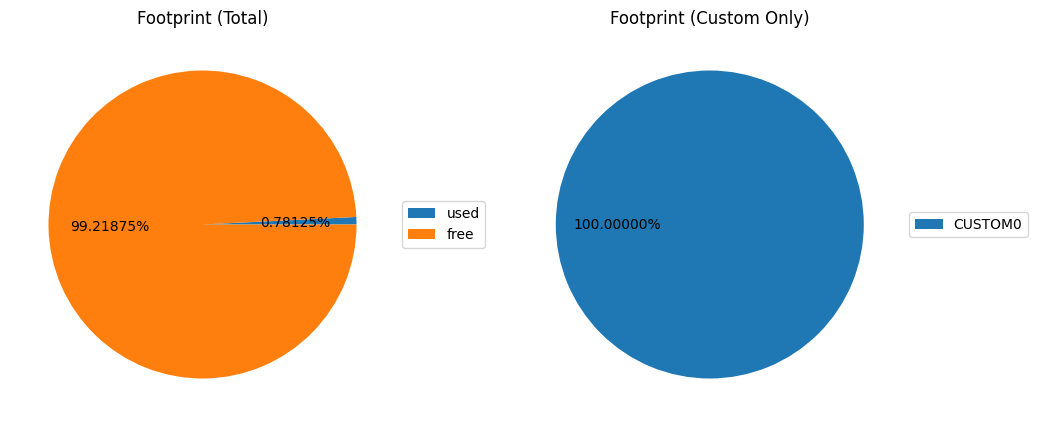

In [47]:
_ = plot_enc_pie_multi(weight_per_instr, rest_weight=rest_weight)

Number of candidates

In [48]:
num_candidates

1

## Generation of Instruction Set

Investigate generated Flat (unfused) CoreDSL per instruction

In [49]:
gen_dir = WORK / "gen"
for file in gen_dir.glob("*.flat"):
    display(HTML(f"<h3>File: {file.name}</h2>"))
    with open(file, "r") as f:
        code = f.read()
    display(Markdown(f"```c\n{code}\n```"""))

```c
// DateTime: 20250129T113918, Sub: 0, Name: name0, Inputs: 3, Outputs: 1
unsigned<32> rs3_val=X[rs3];
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD((unsigned<32>)(MUL(rs1_val,rs2_val)),rs3_val));
X[rd]=outp0;
```

CoreDSL Set with automatic encoding

In [50]:
set_file = WORK / "XIsaac.core_desc"

with open(set_file, "r") as f:
    code = f.read()

display(Markdown(f"```c\n{code}\n```"""))

FileNotFoundError: [Errno 2] No such file or directory: '../out/rnnoise_INT8/20250129T100017/work/XIsaac.core_desc'

## LLVM Retargeting

## Seal5 Reports

In [27]:
reports_dir = WORK / "docker" / "seal5_reports"

### Properties

In [28]:
properties_csv = reports_dir / "properties.csv"
pd.read_csv(properties_csv)

,model,set,xlen,is_rv32,is_rv64,instr,enc_size,is_compressed,enc_format,opcode,...,is_siso,is_simo,has_imm_leaf,has_side_effects,may_load,may_store,is_terminator,is_branch,uses_custom_reg,defs_custom_reg
0,XIsaac,XIsaac,32,True,False,CUSTOM0,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
1,XIsaac,XIsaac,32,True,False,CUSTOM1,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
2,XIsaac,XIsaac,32,True,False,CUSTOM2,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
3,XIsaac,XIsaac,32,True,False,CUSTOM3,32,False,r-type (unop),custom-3,...,True,False,False,False,False,False,False,False,False,False
4,XIsaac,XIsaac,32,True,False,CUSTOM4,32,False,r-type (unop),custom-3,...,True,False,False,False,False,False,False,False,False,False
5,XIsaac,XIsaac,32,True,False,CUSTOM5,32,False,r-type (unop),custom-3,...,True,False,False,False,False,False,False,False,False,False
6,XIsaac,XIsaac,32,True,False,CUSTOM6,32,False,r-type (unop),custom-3,...,True,False,False,False,False,False,False,False,False,False
7,XIsaac,XIsaac,32,True,False,CUSTOM7,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
8,XIsaac,XIsaac,32,True,False,CUSTOM8,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
9,XIsaac,XIsaac,32,True,False,CUSTOM9,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False


### Stage Times

In [65]:
stage_times_csv = reports_dir / "stage_times.csv"
pd.read_csv(stage_times_csv)[["stage", "time_s"]].dropna()

,stage,time_s
0,setup,38.525705
1,patch,18.895561
2,build,873.806360
3,transform,1.505749
4,generate,1.470800
5,patch,11.247951
6,build,59.737247
7,build,7.439931
8,build,7.460552
9,generate,2.102515


### Passes

In [30]:
seal5_status_csv = reports_dir / "status.csv"
seal5_status_compact_csv = reports_dir / "status_compact.csv"
seal5_status_df = pd.read_csv(seal5_status_csv)
seal5_status_compact_df = pd.read_csv(seal5_status_compact_csv)
seal5_status_compact_df

,model,set,xlen,instr,n_success,n_skipped,n_failed,n_total,status
0,XIsaac,XIsaac,32,CUSTOM0,12,0,0,12,good
1,XIsaac,XIsaac,32,CUSTOM1,12,0,0,12,good
2,XIsaac,XIsaac,32,CUSTOM2,12,0,0,12,good
3,XIsaac,XIsaac,32,CUSTOM3,12,0,0,12,good
4,XIsaac,XIsaac,32,CUSTOM4,12,0,0,12,good
5,XIsaac,XIsaac,32,CUSTOM5,12,0,0,12,good
6,XIsaac,XIsaac,32,CUSTOM6,12,0,0,12,good
7,XIsaac,XIsaac,32,CUSTOM7,12,0,0,12,good
8,XIsaac,XIsaac,32,CUSTOM8,12,0,0,12,good
9,XIsaac,XIsaac,32,CUSTOM9,12,0,0,12,good


### Test Results/Coverage

In [31]:
# test_coverage_compact_csv = reports_dir / "test_coverage_compact.csv"
# pd.read_csv(test_coverage_compact_csv)

In [32]:
# test_results_compact_csv = reports_dir / "test_results_compact.csv"
# pd.read_csv(test_results_compact_csv)

### Changed Files/Lines

In [33]:
seal5_diff_csv = reports_dir / "diff.csv"
seal5_diff_df = pd.read_csv(seal5_diff_csv)
seal5_diff_df

,phase,n_files_changed,n_insertions,n_deletions
0,PHASE_0,29,4402,5
1,PHASE_1,3,15,0
2,PHASE_2,15,570,0
3,PHASE_3,0,0,0
4,PHASE_4,14,143,0
5,PHASE_5,0,0,0
6,*,57,5130,5


In [34]:
seal5_diff_csv

PosixPath('../out/nettle-aes/20241202T160512/work/docker/seal5_reports/diff.csv')

seal5_phases ['PHASE_1', 'PHASE_2', 'PHASE_3', 'PHASE_4', 'PHASE_5']


,step,n_files_changed,n_insertions,n_deletions
0,seal5,32,728,0
1,etiss,1,986,0


### Seal5 Score

In [64]:
seal5_score_data = []
seal5_pattern_gen_status_df = seal5_status_df[seal5_status_df["pass"] == "generate_passes.pattern_gen.behav_to_pat"][["instr", "status"]]
seal5_passes_status_df = seal5_status_compact_df[["instr", "status"]]
# print("seal5_passes_status_df", seal5_passes_status_df)
for instr_name in seal5_status_df["instr"].unique():
    # print("instr_name", instr_name)
    passes_status = seal5_passes_status_df[seal5_passes_status_df["instr"] == instr_name]
    assert len(passes_status) == 1
    passes_status = passes_status["status"].iloc[0]
    passes_score = 1.0 if passes_status == "good" else (0.5 if passes_status == "ok" else 0.0)
    
    pattern_gen_status = seal5_pattern_gen_status_df[seal5_pattern_gen_status_df["instr"] == instr_name]
    assert len(pattern_gen_status) == 1
    pattern_gen_status = pattern_gen_status["status"].iloc[0]
    # print("pattern_gen_status", pattern_gen_status)
    pattern_gen_score = 1.0 if pattern_gen_status == "success" else -1.0
    # print("pattern_gen_score", pattern_gen_score)
    
    new = {"instr": instr_name, "pattern_gen_score": pattern_gen_score, "passes_score": passes_score}
    seal5_score_data.append(new)
    
def calc_seal5_score(x):
    return x.min()

seal5_score_df = pd.DataFrame(seal5_score_data)
seal5_score_df["seal5_score"] =  seal5_score_df[["pattern_gen_score", "passes_score"]].apply(calc_seal5_score, axis=1)
seal5_score_df
# TODO: write to file

,instr,pattern_gen_score,passes_score,seal5_score
0,CUSTOM0,1.0,1.0,1.0
1,CUSTOM1,1.0,1.0,1.0
2,CUSTOM2,1.0,1.0,1.0
3,CUSTOM3,1.0,1.0,1.0
4,CUSTOM4,1.0,1.0,1.0
5,CUSTOM5,1.0,1.0,1.0
6,CUSTOM6,1.0,1.0,1.0
7,CUSTOM7,1.0,1.0,1.0
8,CUSTOM8,1.0,1.0,1.0
9,CUSTOM9,1.0,1.0,1.0


## ISS Evaluation

In [47]:
RUN_COMPARE = Path(str(RUN) + "_compare")
REPORT_COMPARE = RUN_COMPARE / "report.csv"

COLS = ["Model", "Arch", "Run Instructions", "Run Instructions (rel.)"]
bench_compare_df = pd.read_csv(REPORT_COMPARE)[COLS]
bench_compare_df

,Model,Arch,Run Instructions,Run Instructions (rel.)
0,nettle-aes,rv32imfd,3573210,1.000000
1,nettle-aes,rv32imfd_xisaac,2654136,0.742788


In [48]:
#TEMP
RUN_COMPARE = Path(str(RUN) + "_compare")
REPORT_COMPARE = RUN_COMPARE / "report.csv"

COLS = ["Model", "Arch", "Run Instructions", "Run Instructions (rel.)"]
bench_compare_df = pd.read_csv(REPORT_COMPARE)[COLS]
bench_compare_df

,Model,Arch,Run Instructions,Run Instructions (rel.)
0,nettle-aes,rv32imfd,3573210,1.000000
1,nettle-aes,rv32imfd_xisaac,2654136,0.742788


In [49]:
RUN_COMPARE_MEM = Path(str(RUN) + "_compare_mem")
REPORT_COMPARE_MEM = RUN_COMPARE_MEM / "report.csv"

COLS = ["Model", "Arch", "Total ROM", "Total RAM", "ROM code", "ROM code (rel.)"]
bench_compare_mem_df = pd.read_csv(REPORT_COMPARE_MEM)[COLS]
bench_compare_mem_df

,Model,Arch,Total ROM,Total RAM,ROM code,ROM code (rel.)
0,nettle-aes,rv32imfd,15956,2744,6140,1.000000
1,nettle-aes,rv32imfd_xisaac,15840,2744,6024,0.981107


In [50]:
# temp
RUN_COMPARE_MEM = Path(str(RUN) + "_compare_mem")
REPORT_COMPARE_MEM = RUN_COMPARE_MEM / "report.csv"

COLS = ["Model", "Arch", "Total ROM", "Total RAM", "ROM code", "ROM code (rel.)"]
bench_compare_mem_df = pd.read_csv(REPORT_COMPARE_MEM)[COLS]
bench_compare_mem_df

,Model,Arch,Total ROM,Total RAM,ROM code,ROM code (rel.)
0,nettle-aes,rv32imfd,15956,2744,6140,1.000000
1,nettle-aes,rv32imfd_xisaac,15840,2744,6024,0.981107


### MLonMCU Score (Set)

In [51]:
assert len(bench_compare_df) == 2
run_instrs_rel = bench_compare_df["Run Instructions (rel.)"].iloc[-1]
assert len(bench_compare_mem_df) == 2
rom_code_rel = bench_compare_mem_df["ROM code (rel.)"].iloc[-1]

run_instrs_score = 1.0/run_instrs_rel-1
rom_code_score = 1.0/rom_code_rel-1

# TODO: cycles!

RUN_INSTR_WEIGHT_POS = 2
ROM_CODE_WEIGHT_POS = 1
RUN_INSTR_WEIGTH_NEG = 10
ROM_CODE_WEIGHT_NEG = 2

mlonmcu_set_score_data = [{"set": "XIsaac", "run_instrs_score": run_instrs_score, "rom_code_score": rom_code_score}]

def calc_mlonmcu_score(x):
    # return gmean([x["run_instrs_score"], x["rom_code_score"]], weights=[RUN_INSTR_WEIGHT, ROM_CODE_WEIGHT])
    a = x["run_instrs_score"]
    a = a * RUN_INSTR_WEIGHT_POS if a > 0 else a * RUN_INSTR_WEIGTH_NEG
    print(a)
    b = x["rom_code_score"]
    b = b * ROM_CODE_WEIGHT_POS if b > 0 else b * ROM_CODE_WEIGHT_NEG
    print(b)
    temp = a + b
    return max(-1.0, min(1.0, temp))

mlonmcu_set_score_df = pd.DataFrame(mlonmcu_set_score_data)
mlonmcu_set_score_df["mlonmcu_score"] =  mlonmcu_set_score_df[["run_instrs_score", "rom_code_score"]].apply(calc_mlonmcu_score, axis=1)
mlonmcu_set_score_df
# TODO: write to file

0.6925598386819667
0.019256308100929598


,set,run_instrs_score,rom_code_score,mlonmcu_score
0,XIsaac,0.34628,0.019256,0.711816


## Dynamic Analysis

In [52]:
SESS_NEW = DATE_DIR / "sess_new"
PLOTS_DIR_NEW = SESS_NEW / "plots"

In [53]:
IFrame(PLOTS_DIR_NEW / "runtime_per_llvm_bb.jpg", 700, 350)

In [54]:
IFrame(PLOTS_DIR_NEW / "runtime_per_func.jpg", 700, 350)

In [55]:
IFrame(PLOTS_DIR_NEW / "runtime_per_opcode.jpg", 700, 350)

In [56]:
IFrame(PLOTS_DIR_NEW / "runtime_per_instr.jpg", 700, 350)

In [57]:
opcodes_hist_file = SESS_NEW / "table" / "opcodes_hist.pkl"
opcodes_hist_df = pd.read_pickle(opcodes_hist_file)
print("All opcodes:")
display(opcodes_hist_df)
print("Custom only:")
display(opcodes_hist_df[opcodes_hist_df["opcode"].apply(lambda x: "custom" in x)])

All opcodes:


,opcode,count,rel_count
0,LOAD,822071,0.307636
1,OP,711326,0.266193
2,custom-3/rv128,535395,0.200356
3,OP-IMM,455728,0.170543
4,BRANCH,69765,0.026108
5,STORE,63971,0.023939
6,JAL,4532,0.001696
7,OP-IMM (Compressed),2175,0.000814
8,JALR (Compressed),1899,0.000711
9,STORE (Compressed),1649,0.000617


Custom only:


,opcode,count,rel_count
2,custom-3/rv128,535395,0.200356


In [58]:
instrs_hist_file = SESS_NEW / "table" / "instrs_hist.pkl"
instrs_hist_df = pd.read_pickle(instrs_hist_file)
print("All instructions:")
display(instrs_hist_df)
print("Custom only:")
custom_instrs_hist_df = instrs_hist_df[instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(custom_instrs_hist_df)

All instructions:


,instr,count,rel_count
0,lw,726360,2.718189e-01
1,xor,561020,2.099453e-01
2,andi,146377,5.477730e-02
3,custom1,133851,5.008981e-02
4,custom11,133848,5.008869e-02
...,...,...,...
63,ori,11,4.116428e-06
64,auipc,11,4.116428e-06
65,csrai,6,2.245324e-06
66,sll,2,7.484414e-07


Custom only:


,instr,count,rel_count
3,custom1,133851,0.050090
4,custom11,133848,0.050089
5,custom2,133848,0.050089
6,custom7,133848,0.050089


In [ ]:
# temp
instrs_hist_file = SESS_NEW / "table" / "instrs_hist.pkl"
instrs_hist_df = pd.read_pickle(instrs_hist_file)
print("All instructions:")
display(instrs_hist_df)
print("Custom only:")
custom_instrs_hist_df = instrs_hist_df[instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(custom_instrs_hist_df)

In [ ]:
dyn_counts_score_data = []

merged_custom_instrs_hist_df = pd.merge(names_df, custom_instrs_hist_df, how="outer", left_on="instr_lower", right_on="instr", suffixes=('', '_y'))

COUNT_WEIGHT = 1
CUSTOM_COUNT_WEIGHT = 1

instr_count_sum = instrs_hist_df["count"].sum()
instr_count_max = instrs_hist_df["count"].max()
print("instr_count", instr_count_sum, instr_count_max)
custom_count_sum = merged_custom_instrs_hist_df["count"].sum()
custom_count_max = merged_custom_instrs_hist_df["count"].max()
print("custom_count", custom_count_sum, custom_count_max)

for _, row_df in merged_custom_instrs_hist_df.iterrows():
    instr = row_df["instr"]
    count = row_df["count"]
    # rel_count = row_df["rel_count"]
    used = count > 0
    used_score = 1.0 if used else -1.0
    count_score = count/instr_count_max if used else -1.0
    custom_count_score = count/custom_count_max if used else -1.0
    new = {"instr": instr, "used_score": used_score, "count_score": count_score, "custom_count_score": custom_count_score}
    dyn_counts_score_data.append(new)

dyn_counts_score_df = pd.DataFrame(dyn_counts_score_data)
dyn_counts_score_df
# TODO: write to file

## Static Analysis

### Instructions

In [59]:
disass_instrs_hist_file = SESS_NEW / "table" / "disass_instrs_hist.pkl"
disass_instrs_hist_df = pd.read_pickle(disass_instrs_hist_file)
print("All instructions:")
display(disass_instrs_hist_df)
print("Custom only:")
diass_custom_instrs_hist_df = disass_instrs_hist_df[disass_instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(diass_custom_instrs_hist_df)
print("Pie:")
display(IFrame(PLOTS_DIR_NEW / "disass_counts_per_instr.jpg", 700, 350))

All instructions:


,instr,count,rel_count
0,sw,2233,0.144634
1,lw,2201,0.142561
2,addi,1623,0.105123
3,li,1151,0.074551
4,mv,1120,0.072544
...,...,...,...
83,rdinstret,1,0.000065
84,rdcycle,1,0.000065
85,divu,1,0.000065
86,fneg.d,1,0.000065


Custom only:


,instr,count,rel_count
52,custom1,11,0.000712
55,custom7,9,0.000583
54,custom11,9,0.000583
53,custom2,9,0.000583


Pie:


In [60]:
# temp
disass_instrs_hist_file = SESS_NEW / "table" / "disass_instrs_hist.pkl"
disass_instrs_hist_df = pd.read_pickle(disass_instrs_hist_file)
print("All instructions:")
display(disass_instrs_hist_df)
print("Custom only:")
diass_custom_instrs_hist_df = disass_instrs_hist_df[disass_instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(diass_custom_instrs_hist_df)
print("Pie:")
display(IFrame(PLOTS_DIR_NEW / "disass_counts_per_instr.jpg", 700, 350))

All instructions:


,instr,count,rel_count
0,sw,2233,0.144634
1,lw,2201,0.142561
2,addi,1623,0.105123
3,li,1151,0.074551
4,mv,1120,0.072544
...,...,...,...
83,rdinstret,1,0.000065
84,rdcycle,1,0.000065
85,divu,1,0.000065
86,fneg.d,1,0.000065


Custom only:


,instr,count,rel_count
52,custom1,11,0.000712
55,custom7,9,0.000583
54,custom11,9,0.000583
53,custom2,9,0.000583


Pie:


In [63]:
static_counts_score_data = []

merged_diass_custom_instrs_hist_df = pd.merge(names_df, diass_custom_instrs_hist_df, how="outer", left_on="instr_lower", right_on="instr", suffixes=('', '_y'))

COUNT_WEIGHT = 1
CUSTOM_COUNT_WEIGHT = 1

instr_count_sum = disass_instrs_hist_df["count"].sum()
instr_count_max = disass_instrs_hist_df["count"].max()
# print("instr_count", instr_count_sum, instr_count_max)
custom_count_sum = merged_diass_custom_instrs_hist_df["count"].sum()
custom_count_max = merged_diass_custom_instrs_hist_df["count"].max()
# print("custom_count", custom_count_sum, custom_count_max)

for _, row_df in merged_diass_custom_instrs_hist_df.iterrows():
    instr = row_df["instr"]
    count = row_df["count"]
    # rel_count = row_df["rel_count"]
    used = count > 0
    used_score = 1.0 if used else -1.0
    count_score = count/instr_count_max if used else -1.0
    custom_count_score = count/custom_count_max if used else -1.0
    new = {"instr": instr, "used_score": used_score, "count_score": count_score, "custom_count_score": custom_count_score}
    static_counts_score_data.append(new)

static_counts_score_df = pd.DataFrame(static_counts_score_data)
static_counts_score_df
# TODO: write to file

,instr,used_score,count_score,custom_count_score
0,CUSTOM0,-1.0,-1.000000,-1.000000
1,CUSTOM1,1.0,0.004926,1.000000
2,CUSTOM2,1.0,0.004030,0.818182
3,CUSTOM3,-1.0,-1.000000,-1.000000
4,CUSTOM4,-1.0,-1.000000,-1.000000
5,CUSTOM5,-1.0,-1.000000,-1.000000
6,CUSTOM6,-1.0,-1.000000,-1.000000
7,CUSTOM7,1.0,0.004030,0.818182
8,CUSTOM8,-1.0,-1.000000,-1.000000
9,CUSTOM9,-1.0,-1.000000,-1.000000


### Opcodes

In [62]:
disass_opcodes_hist_file = SESS_NEW / "table" / "disass_opcodes_hist.pkl"
disass_opcodes_hist_df = pd.read_pickle(disass_opcodes_hist_file)
print("All instructions:")
display(disass_opcodes_hist_df)
print("Custom only:")
display(disass_opcodes_hist_df[disass_opcodes_hist_df["opcode"].apply(lambda x: "custom" in x)])
print("Pie:")
display(IFrame(PLOTS_DIR_NEW / "disass_counts_per_opcode.jpg", 700, 350))

All instructions:


,opcode,count,rel_count
0,OP-IMM (Compressed),2216,0.143533
1,OP-IMM,1843,0.119373
2,STORE (Compressed),1709,0.110694
3,JALR (Compressed),1690,0.109463
4,LOAD (Compressed),1643,0.106419
5,BRANCH,1252,0.081093
6,OP,1118,0.072414
7,LOAD,827,0.053566
8,STORE,699,0.045275
9,JAL (Compressed),656,0.042490


Custom only:


,opcode,count,rel_count
16,custom-3/rv128,38,0.002461


Pie:


In [ ]:
# TODO: write utilization to file


In [ ]:
PLOTS_DIR_NEW / "disass_counts_per_opcode.jpg"

## HLS Metrics

In [44]:
hls_metrics_csv = WORK / "docker" / "hls" / "hls_metrics.csv"
display(pd.read_csv(hls_metrics_csv))

,instruction,mask,tags,schedule,latency,locs
0,CUSTOM0,0000000----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
1,CUSTOM1,0000001----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
2,CUSTOM2,0000010----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
3,CUSTOM3,000001100000-----000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
4,CUSTOM4,000010000000-----000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
5,CUSTOM5,000010100000-----000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
6,CUSTOM6,000011000000-----000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
7,CUSTOM7,0000111----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
8,CUSTOM8,0001000----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
9,CUSTOM9,0001001----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN


## HW Synthesis Metrics

In [ ]:
syn_best_csv = WORK / "docker" / "hls" / "syn_dir" / "best.csv"
display(pd.read_csv(syn_best_csv))

In [ ]:
syn_metrics_csv = WORK / "docker" / "hls" / "syn_metrics.csv"
display(pd.read_csv(syn_metrics_csv))
# TODO: store baseline (without ext)!

In [ ]:
# TODO: performance estimator?

## LOCs Overview

In [46]:
from locs_helper import get_combined_locs_df
get_combined_locs_df(seal5_diff_csv=seal5_diff_csv, etiss_patch_stat="../out/nettle-aes/20241202T160512/work/docker/etiss_patch.stat", hls_metrics_csv=hls_metrics_csv)

,step,n_files_changed,n_insertions,n_deletions
0,seal5,32,728.0,0
1,etiss,1,986.0,0
2,rtl,1,434.0,0
